# Using RNAseq data to predict neurodegenerative diseases


### Objectives

* Dimensionality reduction, visulization, and feature selection of RNAseq data 
* Build machine learning models using RNAseq data to predict dementia
* Build deep learning models using RNAseq data to predict dementia

### Description of datasets

* The patient info dataset contains demographic (age, sex, race, years of education, etc.) and diagnostic (dementia vs. no dementia) information for 107 unique patients 
* The RNAseq dataset contains expression of ~50,000 RNAs from 4 different regions of the brain. 
* The Columns file comtains information to match RNAseq ids to each unique patient ID.


### Explantion of the original study and data

The  Adult Changes in Thought (ACT) study is a population-based study of brain aging and incident dementia, conducted by Kaiser Permanente Washington Health Research Institute. A specific part of this study, the Aging, Dementia, and Traumatic Brain Injury Study, contains detailed neuropathologic (protein expression) and transcriptomic (RNA expression) characterization of brains from a unique cohort with demographic matched dementia and non-dementia patients. The original aim of the Aging, Dementia, and TBI Study was to study neuropathologic and molecular signatures as a result of severity of TBI. However, the availability of extensive protein and RNA data can potentially be used to identify molecular hallmarks of and to ultimately predict the likelihood of developing dementia. 

* http://aging.brain-map.org/overview/home
* https://help.brain-map.org/display/aging/Documentation

Date 04/16/2022

***

In [1]:
import numpy as np
import pandas as pd

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

In [2]:
donor_file_name='data/DonorInformation.csv'
RNA_file_name='data/fpkm_table_normalized.csv'
columns_file_name='data/columns-samples.csv'

# <font color='blue'> Read in and clean donor information</font> 


Donor information file DonorInformation.csv contains basic donor demographic information and diagnosis.
### This part is the same for both protein and RNA workstream

### Diagnosis:
**act_demented**: Any dementia noted during subject's tenure in the ACT study.\
**nincds_arda_diagnosis**: Clinical description of probable or possible Alzheimer's disease based on NINCDS/ADRDA criteria: 0 (no dementia), 1 (probable Alzheimer's disease), 2 (possible Alzheimer's disease), and 3 (dementia, type unknown).)

In [3]:
donor_df=pd.read_csv(donor_file_name)



#Change donor age to numeric 
donor_df.loc[donor_df["age"] == "95-99", "age"] = '98'
donor_df.loc[donor_df["age"] == "90-94", "age"] = '92'
donor_df.loc[donor_df["age"] == "100+", "age"] = '100'
donor_df['age']=donor_df['age'].astype('int64')

#Change nincds_arda_diagnosis to numeric
conditions = [
    (donor_df['nincds_arda_diagnosis'] == 'No Dementia'),
    (donor_df['nincds_arda_diagnosis'] == "Probable Alzheimer'S Disease"),
    (donor_df['nincds_arda_diagnosis'] == "Possible Alzheimer'S Disease"),
    (donor_df['nincds_arda_diagnosis'] == "Dementia, Type Unknown")
]

values = [0, 1, 2, 3]

donor_df['nincds_arda_diagnosis_n'] = np.select(conditions, values)
donor_df['nincds_arda_diagnosis'] = donor_df['nincds_arda_diagnosis_n']
donor_df=donor_df.drop(columns=['nincds_arda_diagnosis_n'])


#Change sex to numeric
donor_df['sex'] = np.where(donor_df['sex']=='M', 0, 1)
donor_df['tbi'] = np.where(donor_df['ever_tbi_w_loc']=='Y', 0, 1)

#Change act_demented to numeric
donor_df['act_demented'] = np.where(donor_df['act_demented']=='No Dementia', 0, 1)

print('donor_df shape:', donor_df.shape)
print('donor ages:',donor_df['age'].unique())
print('donor nincds_arda_diagnosis:',donor_df['nincds_arda_diagnosis'].unique())
print('donor sexes:',donor_df['sex'].unique())
print('donor act_demented:',donor_df['act_demented'].unique())

print('dementia vs no dementia: \n', donor_df['act_demented'].value_counts())
print('nincds_arda_diagnosis: \n', donor_df['nincds_arda_diagnosis'].value_counts())


donor_df shape: (107, 20)
donor ages: [ 87  98  85  92 100  89  78  83  82  77  81  88  84  86  79]
donor nincds_arda_diagnosis: [0 3 2 1]
donor sexes: [0 1]
donor act_demented: [0 1]
dementia vs no dementia: 
 0    57
1    50
Name: act_demented, dtype: int64
nincds_arda_diagnosis: 
 0    56
1    22
2    21
3     8
Name: nincds_arda_diagnosis, dtype: int64


# <font color='blue'>Read in and process RNA seq data</font> 

In [4]:
RNA_df=pd.read_csv(RNA_file_name)
RNA_df2=RNA_df.set_index('gene_id \ rnaseq_profile_id')
RNA_df3=RNA_df2.T.reset_index()
RNA_df3=RNA_df3.rename(columns={"index": "rnaseq_profile_id"})
RNA_df3.index.names = ['index']
RNA_df3.columns.name=''

In [5]:
RNA_df3

rnaseq_profile_id  499304660  499304661  499304662  499304663  \
index                                                                 
0             488395315   0.655725   4.526404        0.0        0.0   
1             496100277   0.095143   8.855850        0.0        0.0   
2             496100278   0.000000   4.868456        0.0        0.0   
3             496100279   0.000000   4.851842        0.0        0.0   
4             496100281   0.000000   3.600344        0.0        0.0   
...                 ...        ...        ...        ...        ...   
372           496100667   0.000000   5.664388        0.0        0.0   
373           496100669   0.000000   8.329654        0.0        0.0   
374           496100670   0.126133   5.712798        0.0        0.0   
375           496100671   0.000000   4.639818        0.0        0.0   
376           496100672   0.000000   4.708020        0.0        0.0   

       499304664  499304665  499304666  499304667  499304668  ...   499355054  \
index                                                         ...               
0       0.039654        0.0   0.000000    0.00000   0.000000  ...  406.688243   
1       0.016492        0.0   0.000000    0.00000   0.000000  ...  415.503112   
2       0.000000        0.0   0.000000    0.00000   0.000000  ...  524.577960   
3       0.170431        0.0   0.000000    0.00000   0.000000  ...  428.282485   
4       0.000000        0.0   0.000000    0.00000   0.000000  ...  367.205701   
...          ...        ...        ...        ...        ...  ...         ...   
372     0.114818        0.0   0.000000    0.08569   0.000000  ...  650.289541   
373     0.143532        0.0   0.102159    0.00000   0.000000  ...  594.772570   
374     0.000000        0.0   0.000000    0.00000   0.027088  ...  392.597011   
375     0.075834        0.0   0.000000    0.00000   0.000000  ...  699.861970   
376     0.000000        0.0   0.000000    0.00000   0.024740  ...  382.641165   

       499355055  499355056  499355057   499355058  499355059  499355060  \
index                                                                      
0       0.000000        0.0        0.0  177.049256  59.293828   0.000000   
1       0.000000        0.0        0.0  138.242472  24.446436   0.000000   
2       0.000000        0.0        0.0  171.511364  37.608601   3.323079   
3       0.000000        0.0        0.0  176.226091  50.775653   0.000000   
4       0.000000        0.0        0.0  115.521316  43.398201   3.422902   
...          ...        ...        ...         ...        ...        ...   
372     0.000000        0.0        0.0  294.207355  70.488572   0.000000   
373     1.829645        0.0        0.0  268.030605  49.578196   0.000000   
374     0.000000        0.0        0.0  183.648187  58.632013   4.271477   
375     0.000000        0.0        0.0  280.791963  72.621158  10.262135   
376     0.000000        0.0        0.0  252.375193  41.339535   1.962493   

        499355061  499355062  499355063  
index                                    
0      409.916660        0.0   0.000000  
1      375.295129        0.0   0.000000  
2      358.011161        0.0   0.000000  
3      364.972710        0.0   1.255010  
4      259.190920        0.0   6.467808  
...           ...        ...        ...  
372    554.106124        0.0   0.000000  
373    460.322065        0.0   3.533292  
374    482.301655        0.0   0.000000  
375    592.635518        0.0   3.458679  
376    383.616738        0.0   0.000000  

[377 rows x 50282 columns]

### Read in file that matches rnaseq_profile_id to donor_id

In [6]:
columns_df=pd.read_csv(columns_file_name)

In [7]:
columns_df

rnaseq_profile_id   donor_id  donor_name  specimen_id      specimen_name  \
0            488395315  309335467  H14.09.030    309357843  H14.09.030.TCx.01   
1            496100277  309335441  H14.09.004    309357624  H14.09.004.PCx.01   
2            496100278  309335438  H14.09.001    309357596  H14.09.001.PCx.01   
3            496100279  309335438  H14.09.001    309357599  H14.09.001.TCx.01   
4            496100281  309335439  H14.09.002    309357603  H14.09.002.HIP.01   
..                 ...        ...         ...          ...                ...   
372          496100667  467056391  H15.09.103    467179071  H15.09.103.TCx.01   
373          496100669  467056391  H15.09.103    467179068  H15.09.103.PCx.01   
374          496100670  467056406  H15.09.107    467179104  H15.09.107.TCx.01   
375          496100671  467056391  H15.09.103    467179065  H15.09.103.HIP.01   
376          496100672  467056407  H15.09.108    467179110  H15.09.108.PCx.01   

     rna_well_id  polygon_id  structure_id structure_acronym structure_color  \
0      395325172   320817998         10235               TCx         #ebbfd0   
1      320630866   310967169         10557               FWM         #f2f1f0   
2      320630834   310790571         10557               FWM         #f2f1f0   
3      320630838   310790522         10235               TCx         #ebbfd0   
4      320630842   310790372         10294               HIP         #bfb5d5   
..           ...         ...           ...               ...             ...   
372    482655826   480366830         10235               TCx         #ebbfd0   
373    482655822   480363830         10557               FWM         #f2f1f0   
374    482655780   480363840         10235               TCx         #ebbfd0   
375    482655820   480366825         10294               HIP         #bfb5d5   
376    482655784   480363849         10557               FWM         #f2f1f0   

                          structure_name hemisphere  
0                     temporal neocortex       left  
1              white matter of forebrain      right  
2              white matter of forebrain       left  
3                     temporal neocortex       left  
4    hippocampus (hippocampal formation)      right  
..                                   ...        ...  
372                   temporal neocortex      right  
373            white matter of forebrain      right  
374                   temporal neocortex      right  
375  hippocampus (hippocampal formation)      right  
376            white matter of forebrain       left  

[377 rows x 12 columns]

### Get labels for RNA seq data
get dementia (1) and no dementia (0) label from columns and donor info file

In [8]:
label_name = 'act_demented'

columns_df=pd.read_csv(columns_file_name)
columns_df=columns_df.merge(donor_df, how='left', on = 'donor_id')
columns_df=columns_df[['rnaseq_profile_id', 'donor_id', 'structure_acronym']+[label_name] ]
columns_df['donor_id']=columns_df['donor_id'].astype(str)
columns_df['rnaseq_profile_id']=columns_df['rnaseq_profile_id'].astype(str)

In [9]:
RNA_df3=RNA_df3.merge(columns_df, how = 'left', on = 'rnaseq_profile_id')

In [10]:
RNA_df3=RNA_df3.set_index('rnaseq_profile_id')

In [11]:
RNA_df3

499304660  499304661  499304662  499304663  499304664  \
rnaseq_profile_id                                                          
488395315           0.655725   4.526404        0.0        0.0   0.039654   
496100277           0.095143   8.855850        0.0        0.0   0.016492   
496100278           0.000000   4.868456        0.0        0.0   0.000000   
496100279           0.000000   4.851842        0.0        0.0   0.170431   
496100281           0.000000   3.600344        0.0        0.0   0.000000   
...                      ...        ...        ...        ...        ...   
496100667           0.000000   5.664388        0.0        0.0   0.114818   
496100669           0.000000   8.329654        0.0        0.0   0.143532   
496100670           0.126133   5.712798        0.0        0.0   0.000000   
496100671           0.000000   4.639818        0.0        0.0   0.075834   
496100672           0.000000   4.708020        0.0        0.0   0.000000   

                   499304665  499304666  499304667  499304668  499304669  ...  \
rnaseq_profile_id                                                         ...   
488395315                0.0   0.000000    0.00000   0.000000   0.317608  ...   
496100277                0.0   0.000000    0.00000   0.000000   0.955393  ...   
496100278                0.0   0.000000    0.00000   0.000000   1.361740  ...   
496100279                0.0   0.000000    0.00000   0.000000   1.357990  ...   
496100281                0.0   0.000000    0.00000   0.000000   1.005507  ...   
...                      ...        ...        ...        ...        ...  ...   
496100667                0.0   0.000000    0.08569   0.000000   1.204446  ...   
496100669                0.0   0.102159    0.00000   0.000000   1.298707  ...   
496100670                0.0   0.000000    0.00000   0.027088   0.660707  ...   
496100671                0.0   0.000000    0.00000   0.000000   1.186791  ...   
496100672                0.0   0.000000    0.00000   0.024740   1.182923  ...   

                   499355057   499355058  499355059  499355060   499355061  \
rnaseq_profile_id                                                            
488395315                0.0  177.049256  59.293828   0.000000  409.916660   
496100277                0.0  138.242472  24.446436   0.000000  375.295129   
496100278                0.0  171.511364  37.608601   3.323079  358.011161   
496100279                0.0  176.226091  50.775653   0.000000  364.972710   
496100281                0.0  115.521316  43.398201   3.422902  259.190920   
...                      ...         ...        ...        ...         ...   
496100667                0.0  294.207355  70.488572   0.000000  554.106124   
496100669                0.0  268.030605  49.578196   0.000000  460.322065   
496100670                0.0  183.648187  58.632013   4.271477  482.301655   
496100671                0.0  280.791963  72.621158  10.262135  592.635518   
496100672                0.0  252.375193  41.339535   1.962493  383.616738   

                   499355062  499355063   donor_id  structure_acronym  \
rnaseq_profile_id                                                       
488395315                0.0   0.000000  309335467                TCx   
496100277                0.0   0.000000  309335441                FWM   
496100278                0.0   0.000000  309335438                FWM   
496100279                0.0   1.255010  309335438                TCx   
496100281                0.0   6.467808  309335439                HIP   
...                      ...        ...        ...                ...   
496100667                0.0   0.000000  467056391                TCx   
496100669                0.0   3.533292  467056391                FWM   
496100670                0.0   0.000000  467056406                TCx   
496100671                0.0   3.458679  467056391                HIP   
496100672                0.0   0.000000  467056407                FWM   

           

In [12]:
X=RNA_df3[RNA_df3.columns[:-3]]


y=RNA_df3[RNA_df3.columns[-2]]

In [13]:
X.iloc[0].describe()

count     50281.000000
mean         13.183270
std         846.327165
min           0.000000
25%           0.000000
50%           0.357998
75%           3.225240
max      148029.815966
Name: 488395315, dtype: float64

<AxesSubplot:>

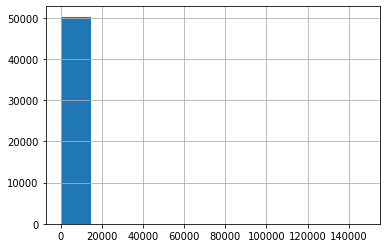

In [14]:
X.iloc[0].hist()

In [15]:
X=np.log(X+0.5)

In [16]:
#Putting codes together
X=RNA_df3[RNA_df3.columns[:-3]]
X=np.log(X+0.5)

y=RNA_df3[RNA_df3.columns[-2]]


<AxesSubplot:>

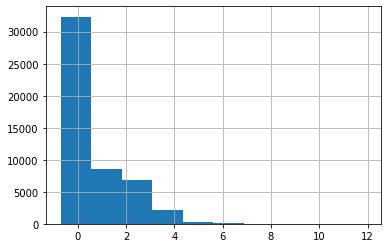

In [17]:
X.iloc[0].hist()

# <font color='blue'>Dimensionality reduction and clustering with tSNE </font>

### Clustering of RNA expression from different brain regions

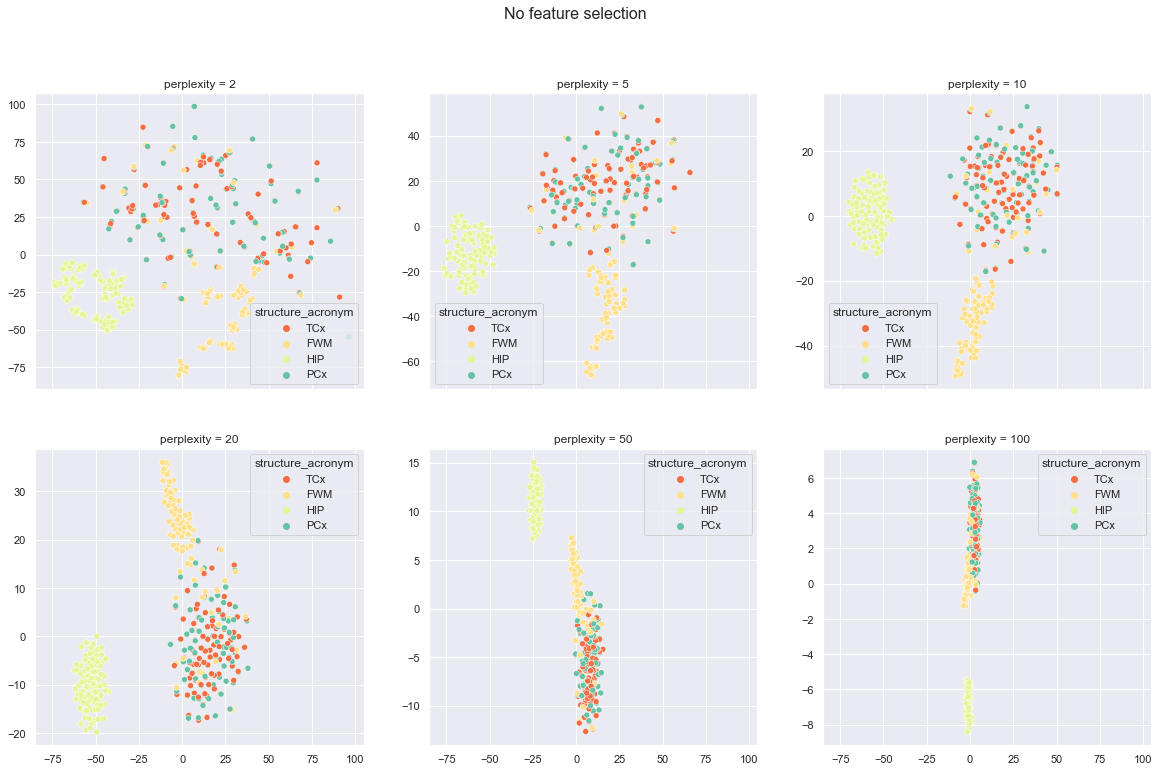

In [18]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

num_groups = 4
perplexities = [2, 5, 10, 20, 50, 100]
nums_features = [10, 50, 100, 200, 500, 1000]


sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("Spectral", num_groups)


#perplexities = [2, 5, 10, 20, 50, 100]
#brain_locs = ['TCx', 'FWM', 'HIP', 'PCx']
#brain_loc=brain_locs[3]

#X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
#y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

i=0
fig,axs = plt.subplots(2,3, figsize=(20,12), sharex=True)
axes = [x[1] for x in enumerate(axs.flat)]
fig.suptitle('No feature selection', fontsize=16)

for n in perplexities:
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=n, init='random')
    X_embedded=tsne.fit_transform(X)
    
    plt.sca(axes[i])
    axes[i].set_title('perplexity = {}'.format(n))
    sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=y, palette = palette, legend='full')
    i+=1

### Clustering of RNA expression from patients with or without dementia 

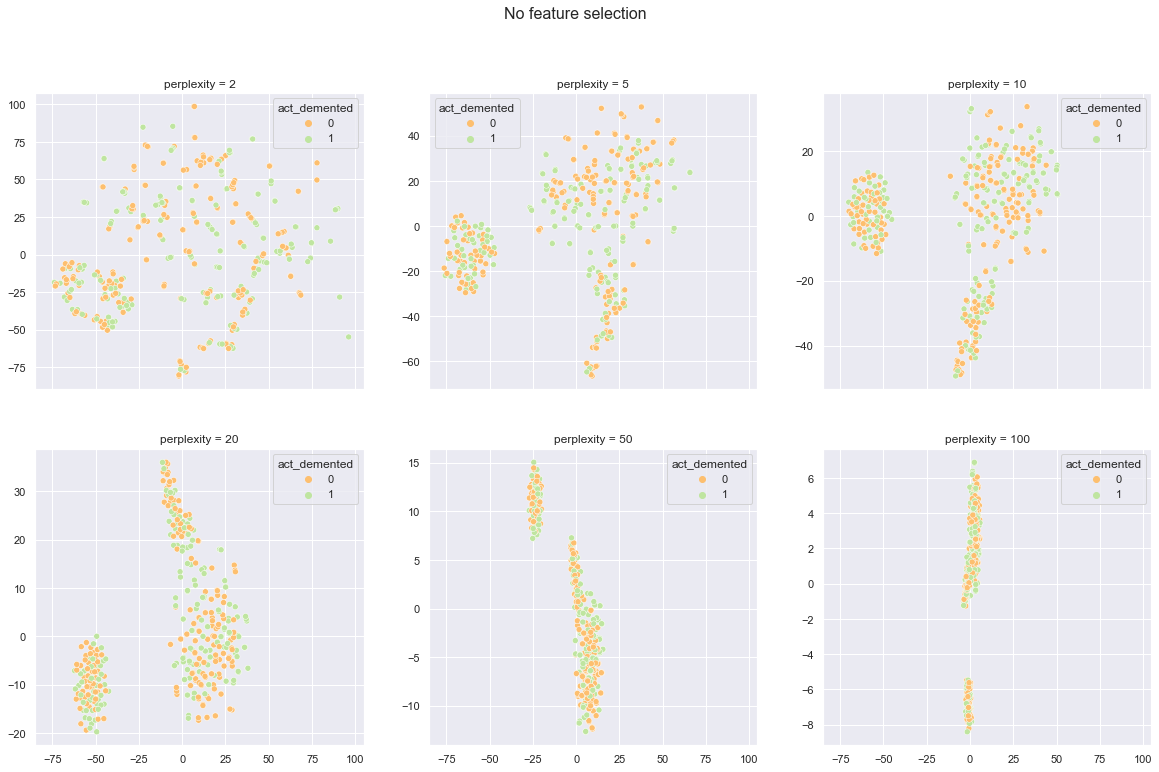

In [19]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

X=RNA_df3[RNA_df3.columns[:-3]]
y=RNA_df3[RNA_df3.columns[-1]]
X=np.log(X+0.5)

num_groups = 2
perplexities = [2, 5, 10, 20, 50, 100]
nums_features = [10, 50, 100, 200, 500, 1000]


sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("Spectral", num_groups)


#perplexities = [2, 5, 10, 20, 50, 100]
#brain_locs = ['TCx', 'FWM', 'HIP', 'PCx']
#brain_loc=brain_locs[3]

#X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
#y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

i=0
fig,axs = plt.subplots(2,3, figsize=(20,12), sharex=True)
axes = [x[1] for x in enumerate(axs.flat)]
fig.suptitle('No feature selection', fontsize=16)

for n in perplexities:
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=n, init='random')
    X_embedded=tsne.fit_transform(X)
    
    plt.sca(axes[i])
    axes[i].set_title('perplexity = {}'.format(n))
    sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=y, palette = palette, legend='full')
    i+=1

### Generate 4 RNAseq datasets with label

In [20]:
#comment out 2nd line to make labels 'nincds_arda_diagnosis'
label_name = 'nincds_arda_diagnosis'
label_name = 'act_demented'

columns_df=pd.read_csv(columns_file_name)
columns_df=columns_df.merge(donor_df, how='left', on = 'donor_id')
columns_df=columns_df[['rnaseq_profile_id', 'donor_id', 'structure_acronym']+[label_name] ]
columns_df['donor_id']=columns_df['donor_id'].astype(str)

In [21]:
brain_locs = ['TCx', 'FWM', 'HIP', 'PCx']

ids_dfs={}
RNA_dfs={}

print('shape of each dataset:')

for brain_loc in brain_locs:

    ids_dfs[brain_loc]=columns_df[columns_df['structure_acronym']==brain_loc]
    ids=[RNA_df.columns[0]]+ids_dfs[brain_loc]['rnaseq_profile_id'].astype(str).tolist()
    RNA_dfs[brain_loc]=RNA_df[ids]
    RNA_dfs[brain_loc].columns=[RNA_df.columns[0]]+ids_dfs[brain_loc]['donor_id'].astype(str).tolist()
    RNA_dfs[brain_loc]=RNA_dfs[brain_loc].rename(columns={"gene_id \ rnaseq_profile_id": "RNAseq_id"})
    
    RNA_dfs[brain_loc]=RNA_dfs[brain_loc].T
    RNA_dfs[brain_loc].columns=RNA_dfs[brain_loc].loc['RNAseq_id']
    RNA_dfs[brain_loc]=RNA_dfs[brain_loc].drop(RNA_dfs[brain_loc].index[0])
    RNA_dfs[brain_loc].columns=RNA_dfs[brain_loc].columns.astype(int).astype(str).tolist()
    
#log transform
#To see results from non-transformed data, comment out line below:
    #RNA_dfs[brain_loc]=np.log(RNA_dfs[brain_loc]+0.5)
    
    
    RNA_dfs[brain_loc]=RNA_dfs[brain_loc].reset_index()
    RNA_dfs[brain_loc]=RNA_dfs[brain_loc].rename(columns={"index": "donor_id"})
   
    columns_df_t=columns_df[columns_df['structure_acronym']==brain_loc]
    
   
    RNA_dfs[brain_loc]=RNA_dfs[brain_loc].merge(columns_df_t, how='inner', on='donor_id')
    RNA_dfs[brain_loc]=RNA_dfs[brain_loc].drop(columns=['rnaseq_profile_id', 'structure_acronym'])
    
   
    RNA_dfs[brain_loc]=RNA_dfs[brain_loc].set_index('donor_id')
    
    
    #Remove columns with constant value
    RNA_dfs[brain_loc]=RNA_dfs[brain_loc].loc[:, (RNA_dfs[brain_loc] != RNA_dfs[brain_loc].iloc[0]).any()] 
#    X=np.log(RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]+0.5)
    
    
    print(brain_loc, RNA_dfs[brain_loc].shape)
    

shape of each dataset:
TCx (99, 45210)
FWM (93, 45003)
HIP (94, 45340)
PCx (91, 45004)


In [22]:
#look at one of the dataframe
RNA_dfs['TCx']

499304660  499304661  499304662  499304664  499304666  499304667  \
donor_id                                                                      
309335467   0.655725   4.526404        0.0   0.039654        0.0    0.00000   
309335438   0.000000   4.851842        0.0   0.170431        0.0    0.00000   
309335439   0.151241   4.830538        0.0   0.087973        0.0    0.00000   
309335440   0.172735   4.565007        0.0   0.000000        0.0    0.10759   
309335441   0.515216   5.265749        0.0   0.000000        0.0    0.00000   
...              ...        ...        ...        ...        ...        ...   
467056397   0.225800   4.605528        0.0   0.040716        0.0    0.00000   
467056408   0.385791   6.410127        0.0   0.037582        0.0    0.00000   
467056405   0.464819   3.933522        0.0   0.073427        0.0    0.00000   
467056391   0.000000   5.664388        0.0   0.114818        0.0    0.08569   
467056406   0.126133   5.712798        0.0   0.000000        0.0    0.00000   

           499304668  499304669  499304670  499304671  ...   499355054  \
donor_id                                               ...               
309335467   0.000000   0.317608   0.121604   1.499643  ...  406.688243   
309335438   0.000000   1.357990   0.357331   1.814949  ...  428.282485   
309335439   0.000000   0.969436   0.000000   0.922825  ...  376.928336   
309335440   0.000000   1.088673   0.000000   0.614375  ...  312.249300   
309335441   0.000000   0.814786   0.000000   1.302016  ...  440.128927   
...              ...        ...        ...        ...  ...         ...   
467056397   0.000000   1.703574   0.387156   1.122484  ...  452.740611   
467056408   0.000000   0.970214   0.283158   1.156852  ...  418.040334   
467056405   0.000000   0.727877   0.002436   1.230443  ...  496.416011   
467056391   0.000000   1.204446   0.241556   1.774093  ...  650.289541   
467056406   0.027088   0.660707   0.288712   1.992893  ...  392.597011   

           499355055  499355056  499355057   499355058  499355059  499355060  \
donor_id                                                                       
309335467        0.0        0.0        0.0  177.049256  59.293828   0.000000   
309335438        0.0        0.0        0.0  176.226091  50.775653   0.000000   
309335439        0.0        0.0        0.0  159.257390  39.506123   7.195433   
309335440        0.0        0.0        0.0  120.697731  34.014895   0.000000   
309335441        0.0        0.0        0.0  224.991522  60.387525   0.000000   
...              ...        ...        ...         ...        ...        ...   
467056397        0.0        0.0        0.0  212.534456  51.472357   0.000000   
467056408        0.0        0.0        0.0  183.782564  46.622532   0.000000   
467056405        0.0        0.0        0.0  242.672985  53.263396   0.000000   
467056391        0.0        0.0        0.0  294.207355  70.488572   0.000000   
467056406        0.0        0.0        0.0  183.648187  58.632013   4.271477   

            499355061  499355063  act_demented  
donor_id                                        
309335467  409.916660   0.000000             0  
309335438  364.972710   1.255010             0  
309335439  300.710856   0.000000             1  
309335440  369.302275  13.751102             0  
309335441  601.008351   0.000000             0  
...               ...        ...           ...  
467056397  481.651917   0.000000             0  
467056408  398.558178   5.295320             1  
467056405  525.173676   0.000000             0  
467056391  554.106124   0.000000             0  
467056406  482.301655   0.000000             1  

[99 rows x 45210 columns]

# <font color='blue'>Processing only one brain region data at a time </font>

In [23]:
brain_locs = ['TCx', 'FWM', 'HIP', 'PCx']
brain_loc=brain_locs[1]

num_groups = len(columns_df[label_name].unique())

perplexities = [2, 5, 10, 20, 50, 100]
nums_features = [10, 50, 100, 200, 500, 1000]

X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

In [24]:
print('labels: \n', y.value_counts())

labels: 
 0    48
1    45
Name: act_demented, dtype: int64


In [25]:
X

499304660  499304661  499304662  499304663  499304664  499304666  \
donor_id                                                                      
309335441   0.095143   8.855850        0.0        0.0   0.016492   0.000000   
309335438   0.000000   4.868456        0.0        0.0   0.000000   0.000000   
309335439   0.000000   5.496470        0.0        0.0   0.137523   0.000000   
309335444   0.216965   5.600224        0.0        0.0   0.047946   0.000000   
309335443   0.328465   6.637768        0.0        0.0   0.096361   0.000000   
...              ...        ...        ...        ...        ...        ...   
467056409   0.000000   6.238344        0.0        0.0   0.115635   0.000000   
467056406   0.354723   7.913767        0.0        0.0   0.053731   0.000000   
467056397   0.000000   5.335002        0.0        0.0   0.000000   0.000000   
467056391   0.000000   8.329654        0.0        0.0   0.143532   0.102159   
467056407   0.000000   4.708020        0.0        0.0   0.000000   0.000000   

           499304667  499304668  499304669  499304670  ...   499355054  \
donor_id                                               ...               
309335441        0.0    0.00000   0.955393   0.000000  ...  415.503112   
309335438        0.0    0.00000   1.361740   0.001737  ...  524.577960   
309335439        0.0    0.00000   1.519029   0.000000  ...  353.021829   
309335444        0.0    0.00000   1.765337   0.512065  ...  407.992492   
309335443        0.0    0.00000   0.491584   0.485251  ...  307.951990   
...              ...        ...        ...        ...  ...         ...   
467056409        0.0    0.00000   1.709062   0.419213  ...  451.740045   
467056406        0.0    0.00000   0.581386   0.076263  ...  422.861839   
467056397        0.0    0.00000   1.404961   0.274115  ...  661.740946   
467056391        0.0    0.00000   1.298707   0.000000  ...  594.772570   
467056407        0.0    0.02474   1.182923   0.195864  ...  382.641165   

           499355055  499355056  499355057   499355058  499355059  499355060  \
donor_id                                                                       
309335441   0.000000        0.0        0.0  138.242472  24.446436   0.000000   
309335438   0.000000        0.0        0.0  171.511364  37.608601   3.323079   
309335439   0.000000        0.0        0.0  148.754839  47.585662   0.000000   
309335444   0.000000        0.0        0.0  173.030637  49.044435   2.732085   
309335443   0.000000        0.0        0.0   90.440391  37.264421   3.109125   
...              ...        ...        ...         ...        ...        ...   
467056409   0.000000        0.0        0.0  185.556566  49.756676   2.774894   
467056406   0.000000        0.0        0.0  194.594282  46.492104   0.000000   
467056397   0.000000        0.0        0.0  287.326666  62.231018   7.732946   
467056391   1.829645        0.0        0.0  268.030605  49.578196   0.000000   
467056407   0.000000        0.0        0.0  252.375193  41.339535   1.962493   

            499355061  499355062  499355063  
donor_id                                     
309335441  375.295129   0.000000   0.000000  
309335438  358.011161   0.000000   0.000000  
309335439  284.561050   0.000000   3.268784  
309335444  436.918121   0.000000   4.775500  
309335443  297.827414   0.000000   6.794410  
...               ...        ...        ...  
467056409  394.979428   0.000000   0.000000  
467056406  494.558563   1.537569   0.000000  
467056397  548.106026   0.000000   7.914255  
467056391  460.322065   0.000000   3.533292  
467056407  383.616738   0.000000   0.000000  

[93 rows x 45002 columns]

## Generating log transformed features

<AxesSubplot:>

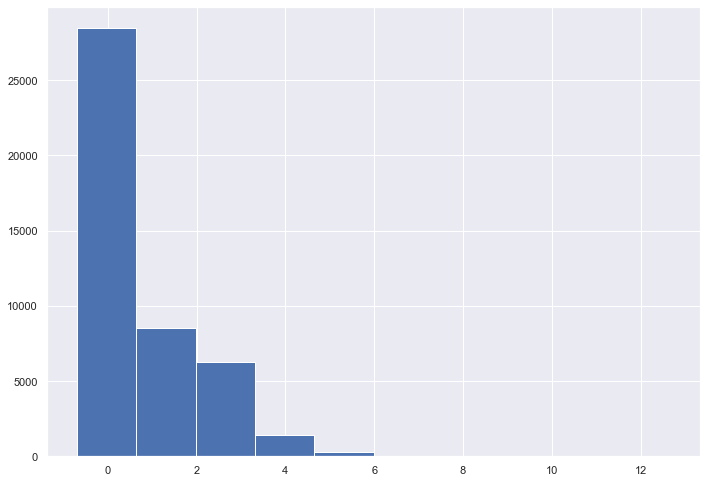

In [26]:
#Reading in untransformed data again to avoid repeated log transformation

brain_locs = ['TCx', 'FWM', 'HIP', 'PCx']
brain_loc=brain_locs[1]

num_groups = len(columns_df[label_name].unique())

perplexities = [2, 5, 10, 20, 50, 100]
nums_features = [10, 50, 100, 200, 500, 1000]

X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

#log transform
X=np.log(X+0.5)

X.iloc[0].hist()

## Visualization using t-SNE

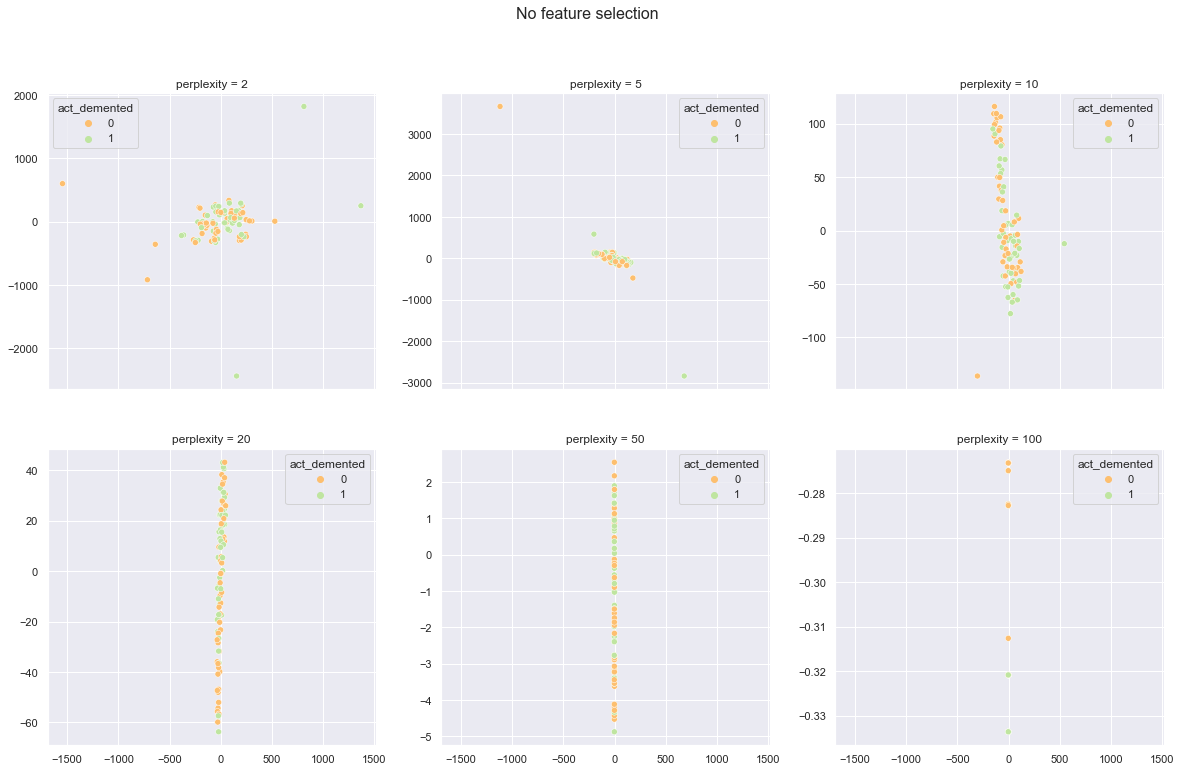

In [27]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns


sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("Spectral", num_groups)


#perplexities = [2, 5, 10, 20, 50, 100]
#brain_locs = ['TCx', 'FWM', 'HIP', 'PCx']
#brain_loc=brain_locs[3]

#X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
#y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

i=0
fig,axs = plt.subplots(2,3, figsize=(20,12), sharex=True)
axes = [x[1] for x in enumerate(axs.flat)]
fig.suptitle('No feature selection', fontsize=16)

for n in perplexities:
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=n, init='random')
    X_embedded=tsne.fit_transform(X)
    
    plt.sca(axes[i])
    axes[i].set_title('perplexity = {}'.format(n))
    sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=y, palette = palette, legend='full')
    i+=1

## tSNE using features after supervised feature selection

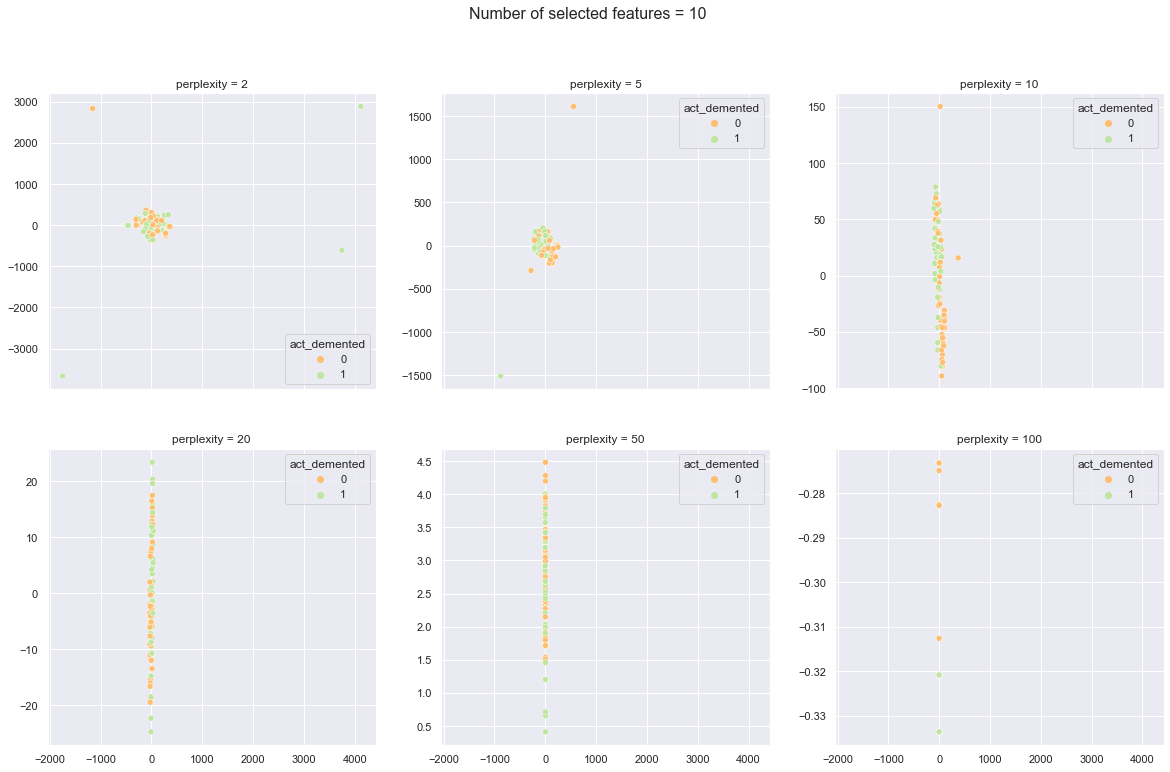

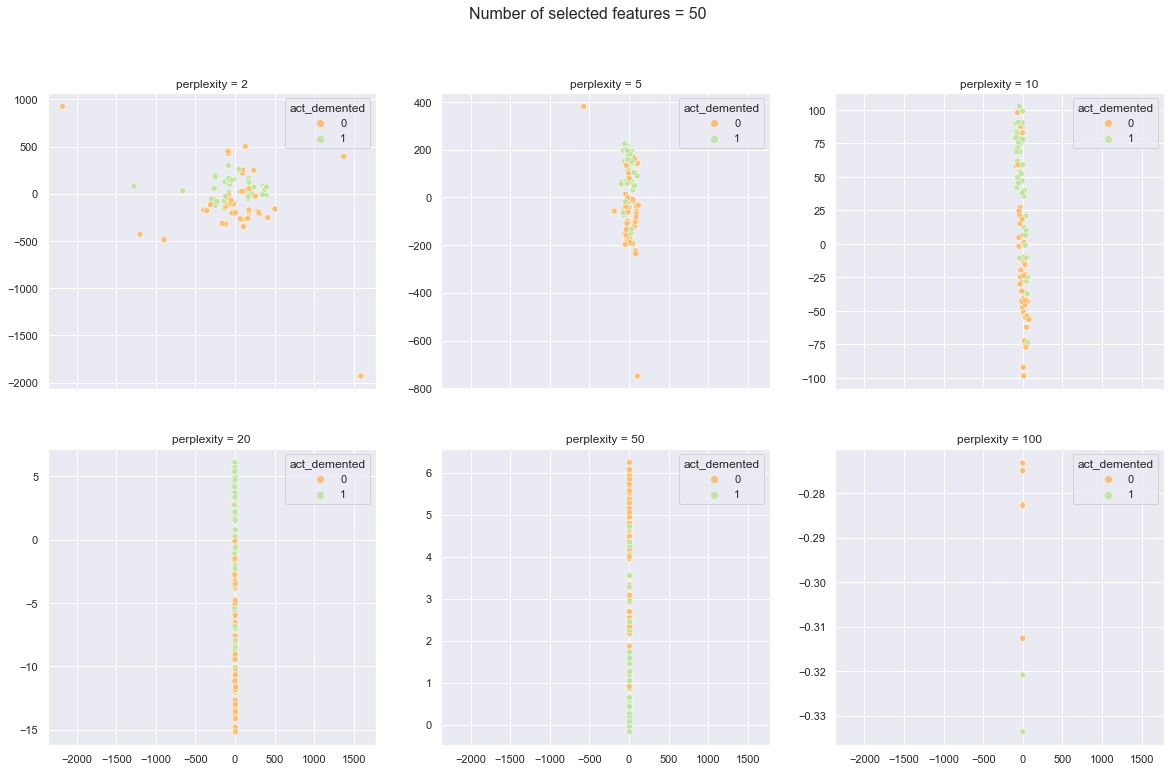

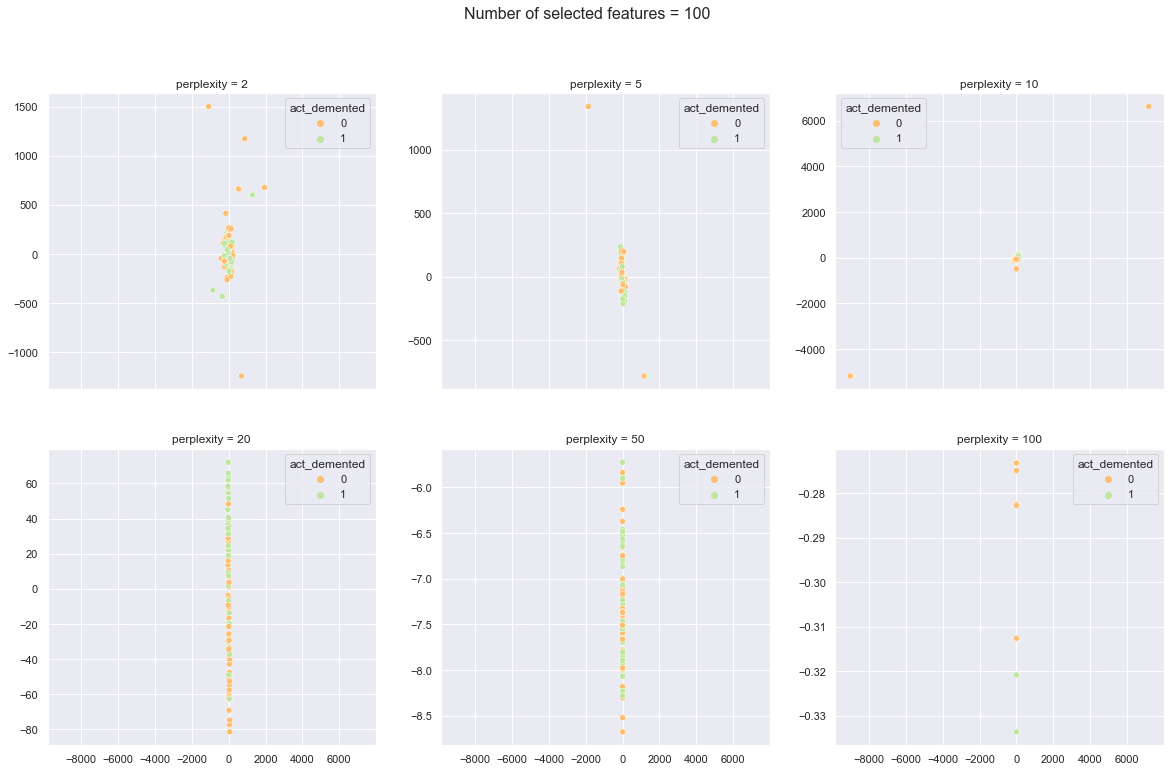

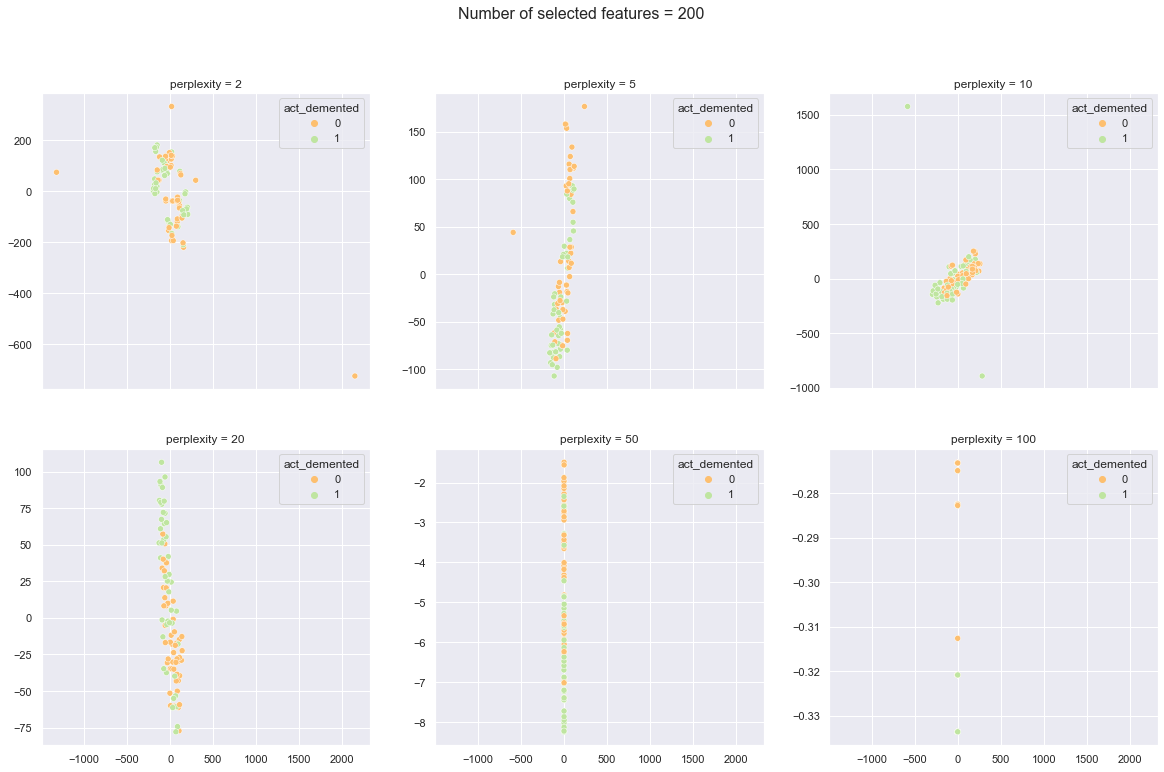

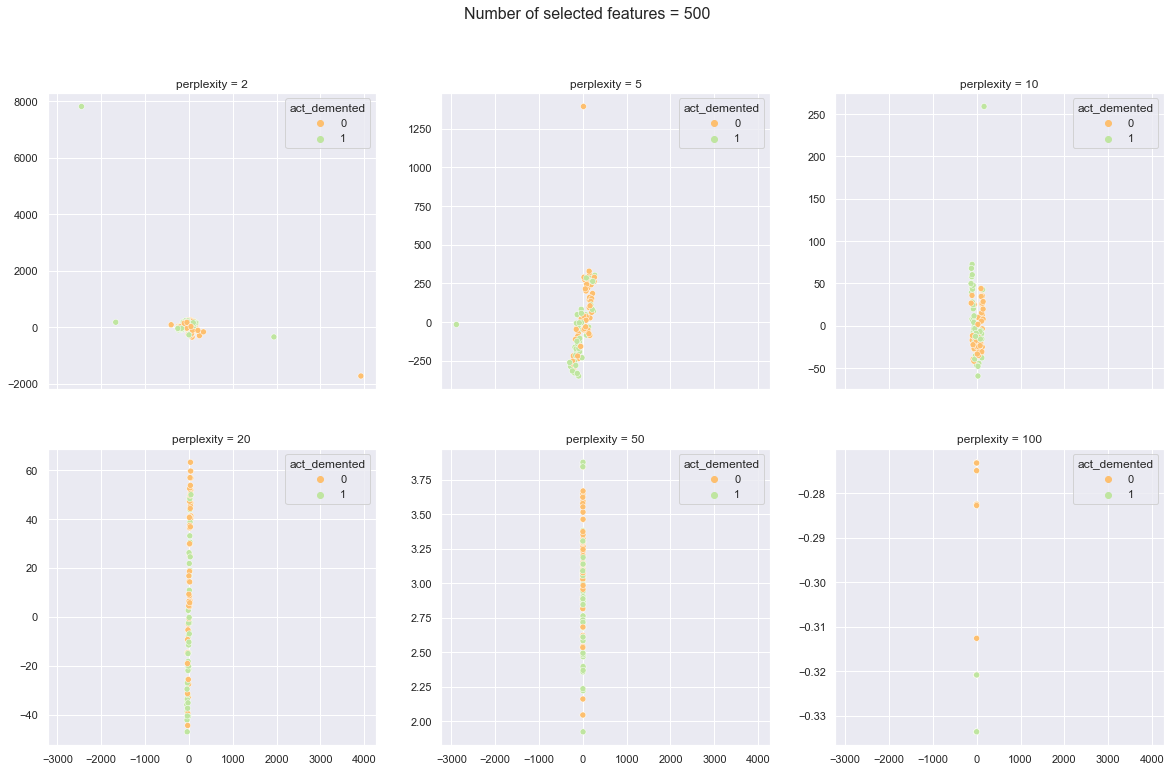

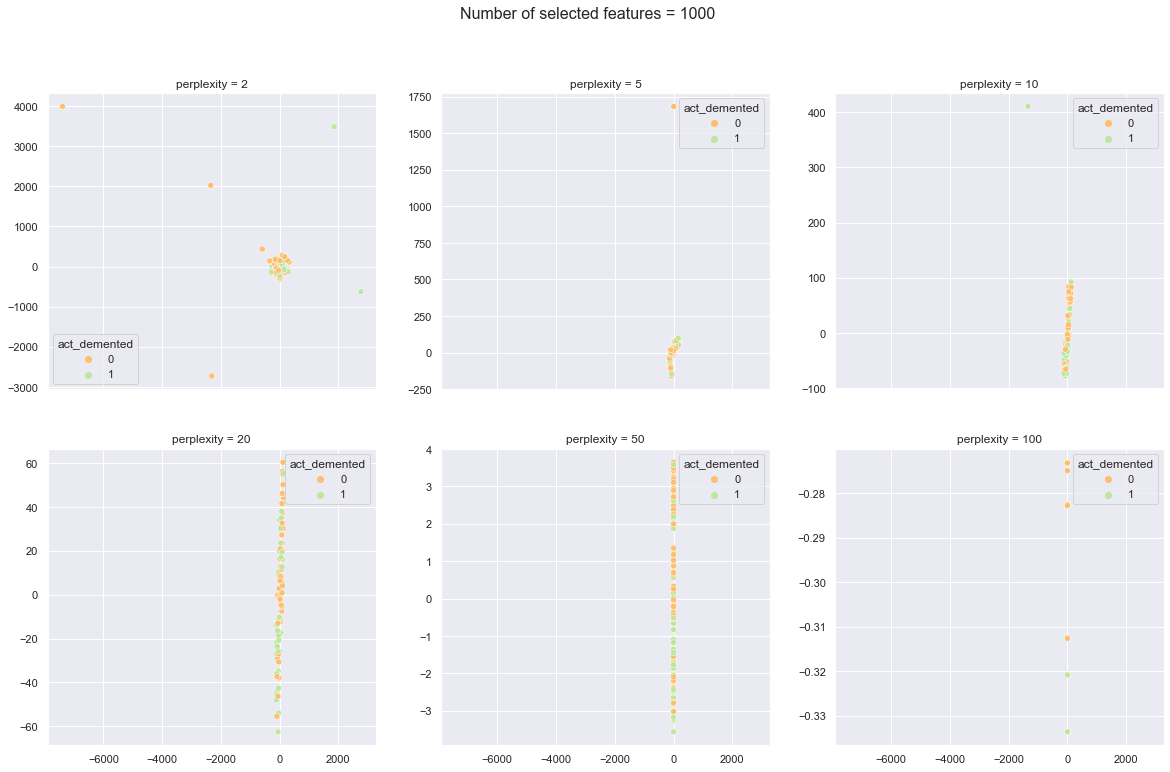

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#perplexities = [2, 5, 10, 20, 50, 100]
#num_features = [10, 50, 100, 200, 500, 1000]

#X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
#y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

for num_features in nums_features:
    test = SelectKBest(k=num_features)
    X_new = test.fit_transform(X, y)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    palette = sns.color_palette("Spectral", num_groups)

    i=0
    fig,axs = plt.subplots(2,3, figsize=(20,12), sharex=True)
    axes = [x[1] for x in enumerate(axs.flat)]
    fig.suptitle('Number of selected features = {}'.format(num_features), fontsize=16)

    for n in [2, 5, 10, 20, 50, 100]:
        tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=n, init='random')
        X_embedded=tsne.fit_transform(X_new)
        plt.sca(axes[i])
        axes[i].set_title('perplexity = {}'.format(n))
        sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue=y, palette = palette, legend='full')
        i+=1

## Supervised Machine Learning using selected features

### supervised feature selection using default score function f_classif - filter

In [29]:
#Logistic regression to classify patients with vs without dementia

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

#brain_locs = ['TCx', 'FWM', 'HIP', 'PCx']
#brain_loc=brain_locs[3]

#X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
#y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

nums_features = [10, 50, 100, 200, 500, 1000]
nums_features = [0] + nums_features

results_df=pd.DataFrame()
results_df['number of features'+ '\\n' +'(0=no selection)']=nums_features

train_accuracies=[]
test_accuracies=[]

for n in nums_features:
    
    if n == 0: #no feature selection
        X_new = X
    else:
        test = SelectKBest(k=n)
        X_new = test.fit_transform(X, y)
#        y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]


    X_train, X_test, y_train, y_test = train_test_split(
         X_new, y, test_size=0.2, random_state=RANDOM_STATE)


    scaler = StandardScaler()
    X_train_s=scaler.fit_transform(X_train)
    X_test_s=scaler.transform(X_test)

    clf = LogisticRegression(random_state=RANDOM_STATE).fit(X_train_s, y_train)
    
    y_pred=clf.predict(X_test_s)
    f1score = f1_score(y_test, y_pred, average='macro')
    train_accuracy = round(clf.score(X_train_s, y_train),3)
    test_accuracy=round(clf.score(X_test_s, y_test),3)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    

#    if n == 0:
#        print ("no feature selection ",'\n', "train accuracy = ", train_accuracy, ", test accuracy = ", test_accuracy)
#    else:
#        print("number of features =", n, '\n', "train accuracy = ", train_accuracy, ", test accuracy = ", test_accuracy)
#    print('---------------------------------')
    

results_df['train_accuracy']=train_accuracies
results_df['test_accuracy']=test_accuracies

from IPython.display import display, HTML

display( HTML( results_df.to_html().replace("\\n","<br>") ) )

### supervised feature selection using RFE (wrapper)
running extremely slow on local computer

In [30]:
# evaluate RFE for classification
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# create pipeline
#rfe = RFE(estimator=LogisticRegression(), n_features_to_select=200)
#model = LogisticRegression()
#pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
#n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
#print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

### Unsupervised feature selection - Variance Threshold

In [31]:
X

499304660  499304661  499304662  499304663  499304664  499304666  \
donor_id                                                                      
309335441  -0.518954   2.236002  -0.693147  -0.693147  -0.660696  -0.693147   
309335438  -0.693147   1.680540  -0.693147  -0.693147  -0.693147  -0.693147   
309335439  -0.693147   1.791171  -0.693147  -0.693147  -0.450165  -0.693147   
309335444  -0.332728   1.808326  -0.693147  -0.693147  -0.601579  -0.693147   
309335443  -0.188181   1.965400  -0.693147  -0.693147  -0.516909  -0.693147   
...              ...        ...        ...        ...        ...        ...   
467056409  -0.693147   1.907814  -0.693147  -0.693147  -0.485102  -0.693147   
467056406  -0.156978   2.129869  -0.693147  -0.693147  -0.591077  -0.693147   
467056397  -0.693147   1.763875  -0.693147  -0.693147  -0.693147  -0.693147   
467056391  -0.693147   2.178116  -0.693147  -0.693147  -0.440784  -0.507234   
467056407  -0.693147   1.650200  -0.693147  -0.693147  -0.693147  -0.693147   

           499304667  499304668  499304669  499304670  ...  499355054  \
donor_id                                               ...              
309335441  -0.693147  -0.693147   0.375276  -0.693147  ...   6.030693   
309335438  -0.693147  -0.693147   0.621512  -0.689678  ...   6.263547   
309335439  -0.693147  -0.693147   0.702617  -0.693147  ...   5.867945   
309335444  -0.693147  -0.693147   0.817724   0.011993  ...   6.012474   
309335443  -0.693147  -0.693147  -0.008452  -0.014859  ...   5.731566   
...              ...        ...        ...        ...  ...        ...   
467056409  -0.693147  -0.693147   0.792568  -0.084237  ...   6.114213   
467056406  -0.693147  -0.693147   0.078244  -0.551191  ...   6.048227   
467056397  -0.693147  -0.693147   0.644461  -0.256035  ...   6.495629   
467056391  -0.693147  -0.693147   0.587068  -0.693147  ...   6.389019   
467056407  -0.693147  -0.644852   0.520532  -0.362600  ...   5.948403   

           499355055  499355056  499355057  499355058  499355059  499355060  \
donor_id                                                                      
309335441  -0.693147  -0.693147  -0.693147   4.932619   3.216731  -0.693147   
309335438  -0.693147  -0.693147  -0.693147   5.147561   3.640440   1.341056   
309335439  -0.693147  -0.693147  -0.693147   5.005655   3.872984  -0.693147   
309335444  -0.693147  -0.693147  -0.693147   5.156354   3.902870   1.173127   
309335443  -0.693147  -0.693147  -0.693147   4.510204   3.631367   1.283465   
...              ...        ...        ...        ...        ...        ...   
467056409  -0.693147  -0.693147  -0.693147   5.226051   3.917143   1.186286   
467056406  -0.693147  -0.693147  -0.693147   5.273483   3.849980  -0.693147   
467056397  -0.693147  -0.693147  -0.693147   5.662358   4.138856   2.108144   
467056391   0.845716  -0.693147  -0.693147   5.592965   3.913586  -0.693147   
467056407  -0.693147  -0.693147  -0.693147   5.532896   3.733842   0.901174   

           499355061  499355062  499355063  
donor_id                                    
309335441   5.929044  -0.693147  -0.693147  
309335438   5.881960  -0.693147  -0.693147  
309335439   5.652703  -0.693147   1.326752  
309335444   6.080890  -0.693147   1.663073  
309335443   5.698192  -0.693147   1.987108  
...              ...        ...        ...  
467056409   5.980099  -0.693147  -0.693147  
467056406   6.204676   0.711757  -0.693147  
467056397   6.307381  -0.693147   2.129927  
467056391   6.133012  -0.693147   1.394583  
467056407   5.950947  -0.693147  -0.693147  

[93 rows x 45002 columns]

In [32]:
min_variance=X.var(axis=0).min()
max_variance=X.var(axis=0).max()
print("min_variance = {},".format(min_variance), "max_variance = {}".format(max_variance))

min_variance = 2.8679786072945954e-06, max_variance = 8.750077922716049


In [33]:
from sklearn.feature_selection import VarianceThreshold

#X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
#y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

variances = [0, 0.01, 0.1, 0.5, 1, 5]



#num_of_variances = 10
#step_size= (X.var(axis=0).max()-X.var(axis=0).min())/num_of_variances

results_df=pd.DataFrame()
results_df['variance threshold']=variances

train_accuracies=[]
test_accuracies=[]
num_features=[]

#for threshold in np.arange(min_variance+step_size, max_variance, step_size):
for threshold in variances:
    
    sel = VarianceThreshold(threshold=threshold)
    X_new=sel.fit_transform(X)
    num_features.append(X_new.shape[1])
    
    
    X_train, X_test, y_train, y_test = train_test_split(
             X_new, y, test_size=0.2, random_state=RANDOM_STATE)


    scaler = StandardScaler()
    X_train_s=scaler.fit_transform(X_train)
    X_test_s=scaler.transform(X_test)


    clf = LogisticRegression(random_state=RANDOM_STATE).fit(X_train_s, y_train)

    y_pred=clf.predict(X_test_s)
    f1score = f1_score(y_test, y_pred, average='macro')
    train_accuracy = round(clf.score(X_train_s, y_train),3)
    test_accuracy= round(clf.score(X_test_s, y_test),3)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
results_df['num of features']=num_features
results_df['train_accuracy']=train_accuracies
results_df['test_accuracy']=test_accuracies

from IPython.display import display, HTML

display( HTML( results_df.to_html().replace("\\n","<br>") ) )

### Unsupervised feature selection/dimensionality reduction - PCA

#### Plot the first two principal components

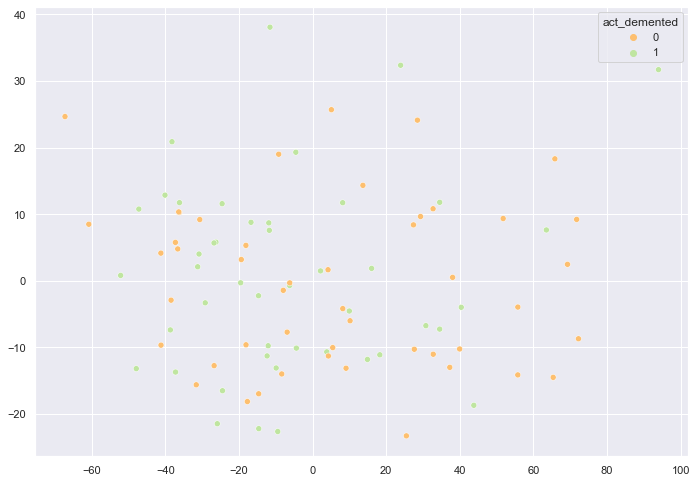

In [34]:
from sklearn.decomposition import PCA

pca = PCA()
X_embedded=pca.fit_transform(X)

sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], palette = palette,hue=y, legend='full');

#### Plot explained variance ratio

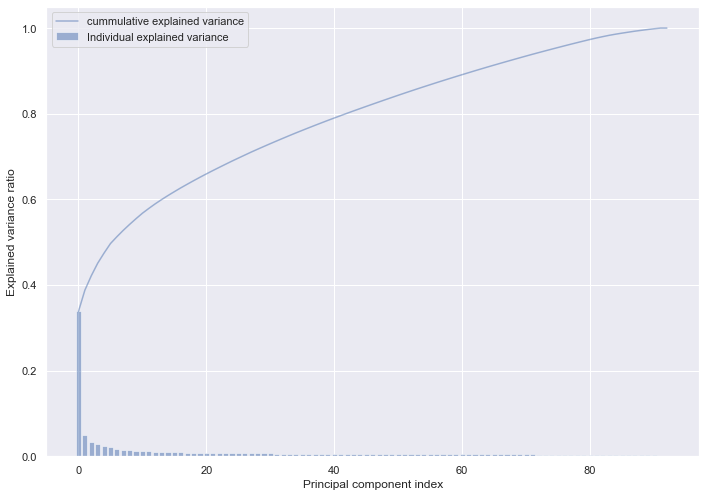

In [35]:
exp_var_pca = pca.explained_variance_ratio_
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.plot(range(0,len(cum_var)), cum_var, alpha=0.5, label='cummulative explained variance')

plt.ylabel('Explained variance ratio');
plt.xlabel('Principal component index');
plt.legend(loc='best');

#### Supervised learning using only principal components

In [36]:
from sklearn.decomposition import PCA


X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
X=np.log(X+0.5)
y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

n_comps = [2, 5, 10, 20, 50]

results_df=pd.DataFrame()


train_accuracies=[]
test_accuracies=[]
num_features=[]

X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.2, random_state=RANDOM_STATE)

for n in n_comps:

    pca = PCA(n_components=n, random_state=RANDOM_STATE)
    X_train_s=pca.fit_transform(X_train)
    X_test_s=pca.transform(X_test)
    

    clf = LogisticRegression(random_state=RANDOM_STATE).fit(X_train_s, y_train)

    y_pred=clf.predict(X_test_s)
    f1score = f1_score(y_test, y_pred, average='macro')
    train_accuracy = round(clf.score(X_train_s, y_train),3)
    test_accuracy= round(clf.score(X_test_s, y_test),3)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
results_df['number of components']=n_comps
results_df['train_accuracy']=train_accuracies
results_df['test_accuracy']=test_accuracies

from IPython.display import display, HTML

display( HTML( results_df.to_html().replace("\\n","<br>") ) )

# Unsupervised Machine Learning - clustering

### k-means clustering

In [37]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE).fit_predict(X)

f1score = f1_score(y, kmeans, average='macro')  
print('f1score=', f1score)

f1score= 0.5584045584045585


### k-means clustering using principal components

In [38]:
from sklearn.decomposition import PCA


#X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
#y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

n_comps = [2, 10, 20, 50]

results_df=pd.DataFrame()


f1scores=[]



for n in n_comps:
    
    pca = PCA(n_components=n,  random_state=RANDOM_STATE)
    X_new=pca.fit_transform(X)

    
    
    #X_train, X_test, y_train, y_test = train_test_split(
             #X_new, y, test_size=0.2, random_state=RANDOM_STATE)


    #scaler = StandardScaler()
    #X_train_s=scaler.fit_transform(X_train)
    #X_test_s=scaler.transform(X_test)


    kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE).fit_predict(X_new)

    f1score = round(f1_score(y, kmeans, average='macro'),3)
    f1scores.append(f1score)

    
    
results_df['number of principal components']=n_comps
results_df['f1scores']=f1scores


from IPython.display import display, HTML

display( HTML( results_df.to_html().replace("\\n","<br>") ) )

### k-means clustering using selected features

In [39]:
#Logistic regression to classify patients with vs without dementia

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

#brain_locs = ['TCx', 'FWM', 'HIP', 'PCx']
#brain_loc=brain_locs[3]

#X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
#y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

variances = [0, 0.01, 0.1, 0.5, 1]

results_df=pd.DataFrame()
results_df['variance threshold']=variances

f1scores=[]

for threshold in variances:
    
    sel = VarianceThreshold(threshold=threshold)
    X_new=sel.fit_transform(X)
    num_features.append(X_new.shape[1])
#        y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]


    #X_train, X_test, y_train, y_test = train_test_split(
         #X_new, y, test_size=0.2, random_state=RANDOM_STATE)


    #scaler = StandardScaler()
    #X_train_s=scaler.fit_transform(X_train)
    #X_test_s=scaler.transform(X_test)

    kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE).fit_predict(X_new)

    f1score = round(f1_score(y, kmeans, average='macro'),3)  
    f1scores.append(f1score)
    


results_df['f1scores']=f1scores


from IPython.display import display, HTML

display( HTML( results_df.to_html().replace("\\n","<br>") ) )

In [40]:
#Logistic regression to classify patients with vs without dementia

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

#brain_locs = ['TCx', 'FWM', 'HIP', 'PCx']
#brain_loc=brain_locs[3]

#X=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[:-1]]
#y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]

nums_features = [10, 50, 100, 500]
nums_features = [0] + nums_features

results_df=pd.DataFrame()
results_df['number of features'+ '\n' +'(0=no selection)']=nums_features

f1scores=[]

for n in nums_features:
    
    if n == 0: #no feature selection
        X_new = X
    else:
        test = SelectKBest(k=n)
        X_new = test.fit_transform(X, y)
#        y=RNA_dfs[brain_loc][RNA_dfs[brain_loc].columns[-1]]


    #X_train, X_test, y_train, y_test = train_test_split(
         #X_new, y, test_size=0.2, random_state=RANDOM_STATE)


    #scaler = StandardScaler()
    #X_train_s=scaler.fit_transform(X_train)
    #X_test_s=scaler.transform(X_test)

    kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE).fit_predict(X_new)

    f1score = round(f1_score(y, kmeans, average='macro'),3)
    f1scores.append(f1score)
    


results_df['f1scores']=f1scores


from IPython.display import display, HTML

display( HTML( results_df.to_html().replace("\\n","<br>") ) )

***
#### Helpful Websites

https://medium.com/swlh/all-you-need-to-know-about-handling-high-dimensional-data-7197b701244d \
https://www.askpython.com/python/examples/plot-k-means-clusters-python\
